In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorboard

In [ ]:
!pip install sacred

     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 99 kB 9.0 MB/s 
     |████████████████████████████████| 180 kB 42.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=d9284ef3dd68ae4a59ec6aa10b08c5de44904474b21e495e3333dde39689dc32
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


In [ ]:
!pip install jsonlines

In [ ]:
!pip install pyconll

In [ ]:
from __future__ import annotations

import random
from typing import Optional, Sequence, List

import jsonlines
import torch
from torch.utils.data import Sampler, Dataset, DataLoader
from random import shuffle

import argparse
import logging
from pathlib import Path
import sys
from typing import Sequence, Set, Optional, Tuple, List
import pyconll
from sklearn.model_selection import KFold
import re
#from language_datasets import LangIDDataSet
from string import digits

import glob

import os
import pickle
import tempfile
import numpy as np
from sacred import Ingredient, Experiment

import math
import time
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from torch import optim
from torch.utils.tensorboard import SummaryWriter

from time import sleep
from sacred.observers import FileStorageObserver

import matplotlib
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import imblearn

from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import json
import glob

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Language_Datasets.py

In [ ]:
class LangIDDataSet(Dataset):
    """
    Basic class to model data sets for language identification.
    """

    def __init__(self, file_path, min_length=1):
        self.initial_data = []
        self.data = []
        self.char_to_idx = {'PAD': 0}
        self.lang_to_idx = {}
        self._load_from_file(file_path, min_length=min_length)
        self.weight_dict = self.make_weight_dict()

    def _load_from_file(self, file_path: Optional[str], min_length=1):
        if file_path is not None:
            char_set = set()
            lang_set = set()
            with jsonlines.open(file_path) as reader:
                for line in reader:
                    if len(line['text']) < min_length:
                        continue
                    self.initial_data.append(line)
                    for c in line['text']:
                        char_set.add(c)
                    lang_set.add(line['label'])
            for c in sorted(char_set):
                if c not in self.char_to_idx.keys():
                    self.char_to_idx[c] = len(self.char_to_idx)
            for lang in sorted(lang_set):
                if lang not in self.lang_to_idx.keys():
                    self.lang_to_idx[lang] = len(self.lang_to_idx)
        self.data = self.initial_data

    def make_weight_dict(self) -> dict:
        """
        Instantiates the weight dict for this dataset
        The formula used is weight = most_frequent/lang_freq.
        Such that the most frequent has a frequency of 1

        :return: A dict with a mapping from a language to weight
        """
        weight_dict = None
        if len(self.initial_data) > 0:
            frequency_dict = {}
            labels = [elem['label'] for elem in self.initial_data]
            for label in self.lang_to_idx.keys():
                frequency_dict[label] = labels.count(label)
            most_frequent = max(frequency_dict.values())
            weight_dict = {label:(most_frequent/frequency_dict[label]) for label in frequency_dict.keys()}
        return weight_dict

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

    @staticmethod
    def make_from_files(files: Sequence[str]) -> LangIDDataSet:
        """
        Creates an instance of LangIDDataSet that contains the content of the given files.
        :param files: list of files to read from
        :return: instance of LangIDDataSet that contains the content of all given files
        """
        if len(files) == 0:
            raise ValueError("No files provided")
        val_to_return = LangIDDataSet(file_path=None)
        for f in files:
            val_to_return._load_from_file(f)
        val_to_return.initial_data = val_to_return.data
        val_to_return.weight_dict = val_to_return.make_weight_dict()
        return val_to_return

    def get_tag_set(self) -> list:
        """returns ordered list of language labels in the dataset
        Returns:
            list -- Ordered list of language labels
        """
        langs = list(self.lang_to_idx.keys())
        langs.sort()
        return langs

    def get_lang_to_idx(self) -> dict:
        """get dict from lang to id, ordered alphabetically
        Returns:
            dict -- For converting language code to an id
        """
        lang_to_idx = {}
        for lang in self.get_tag_set():
            lang_to_idx[lang] = len(lang_to_idx)
        return lang_to_idx

    def randomize_data(self, upper_lim=20, lower_lim=1):
        """
        Takes the original data and creates random length examples with length between upper limit and lower limit
        :param upper_lim: The maximum character length of training example
        :param lower_lim: The minimum character length of training example
        """
        new_data = []
        for line in self.initial_data:
            sentence = line['text']
            label = line['label']
            remaining = sentence
            while lower_lim < len(remaining):
                lim = random.randint(lower_lim, upper_lim)
                m = min(len(remaining), lim)
                new_sentence = remaining[:m]
                new_data.append({'text': new_sentence, 'label': label})
                split = remaining[m:].split(" ", 1)
                if len(split) <= 1:
                    break
                remaining = split[1]
        random.shuffle(new_data)
        self.data = new_data

    def save_data_as_jsonl(self, output_file):
        with jsonlines.open(output_file, mode='w') as writer:
            for line in self.data:
                writer.write(line)


class PyTorchLIDDataSet(Dataset):
    """
    PyTorch-specific wrapper that converts items to PyTorch tensors.
    """

    def __init__(self, decoree: LangIDDataSet):
        self.data = []
        if decoree is not None:
            self.decoree = decoree
        self.char_to_idx = decoree.char_to_idx
        self.lang_to_idx = decoree.lang_to_idx
        self.tensorify_all()

    def __getitem__(self, idx):
        if not isinstance(idx, list):
            return self.data[idx]
        txt = []
        label = []
        for i in idx:
            item = self.data[i]
            txt.append(item[0])
            label.append(item[1])
        return torch.stack(txt), torch.stack(label)

    def make_weight_dict(self) -> dict:
        return self.decoree.make_weight_dict()

    def __len__(self):
        return len(self.data)

    def get_tag_set(self) -> list:
        return self.decoree.get_tag_set()

    def get_char_to_idx(self) -> dict:
        return self.decoree.char_to_idx

    def get_lang_to_idx(self) -> dict:
        """get dict from lang to id, ordered alphabetically
        Returns:
            dict -- For converting language code to an id
        """
        return self.decoree.get_lang_to_idx()

    def randomize_data(self, upper_lim=20, lower_lim=1):
        """
        Takes the original data and creates random length examples with length between upper limit and lower limit.
        :param upper_lim: The maximum character length of training example
        :param lower_lim: The minimum character length of training example
        """
        new_data = []
        for line in self.decoree.initial_data:
            sentence = line['text']
            label = line['label']
            remaining = sentence
            while lower_lim < len(remaining):
                lim = random.randint(lower_lim, upper_lim)
                m = min(len(remaining), lim)
                new_sentence = remaining[:m]
                new_data.append(self.tensorify({'text': new_sentence, 'label': label}))
                split = remaining[m:].split(" ", 1)
                if len(split) <= 1:
                    break
                remaining = split[1]
        random.shuffle(new_data)
        self.data = new_data

    def tensorify(self, data_point):
        sentence = data_point['text']
        lang = data_point['label']
        idxs = [self.char_to_idx.get(c, len(self.char_to_idx)) for c in sentence]
        return torch.tensor(idxs, dtype=torch.long), torch.tensor(self.lang_to_idx[lang], dtype=torch.long)

    def tensorify_all(self):
        new_data = []
        for elem in self.decoree:
            new_data.append(self.tensorify(elem))
        self.data = new_data

    def set_lang_to_idx(self, l_to_idx):
        self.lang_to_idx = l_to_idx
        self.decoree.lang_to_idx = l_to_idx

    def set_char_to_idx(self, c_to_idx):
        self.char_to_idx = c_to_idx
        self.decoree.char_to_idx = c_to_idx


# Based on https://github.com/chrisvdweth/ml-toolkit/blob/master/pytorch/utils/data/text/dataset.py
class BucketBatchSampler(Sampler):
    """
    This class creates batches containing equal length examples.
    """
    def __init__(self, batch_size, inputs):
        self.batch_size = batch_size
        self.input = inputs
        self.batch_list = self._generate_batch_map()
        self.num_batches = len(self.batch_list)

    def _generate_batch_map(self):
        batch_map = {}
        for idx, item in enumerate(self.input):
            length = len(item[0])
            if length not in batch_map:
                batch_map[length] = [idx]
            else:
                batch_map[length].append(idx)
        # Use batch_map to split indices into batches of equal size
        # e.g., for batch_size=3, batch_list = [[23,45,47], [49,50,62], [63,65,66], ...]
        batch_list = []
        for length, indices in batch_map.items():
            for group in [indices[i:(i + self.batch_size)] for i in range(0, len(indices), self.batch_size)]:
                batch_list.append(group)
        return batch_list

    def batch_count(self):
        return self.num_batches

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        shuffle(self.batch_list)
        for i in self.batch_list:
            yield i


Split dataset to folds

In [ ]:
class Args():
    folds= 5
    seed= 1
    max_window= 50
    min_window= 1
    data_source= 'socialmediatext'
    dataset_path= Path('/content/drive/MyDrive/FYP/Final/dataset/LID_WithSenID_2')
    output_path= Path('/content/drive/MyDrive/FYP/Final/dataset/LID_Folds/withSenID_2')
    force= True
    languages= "Sinhala, English, Sin-Eng, Eng-Sin, Mixed, NameEntity, Symbol"
    exact_length= False
    eval_length= 25


In [ ]:
def make_jsonl_from_socialmediatext(dataset_path: Path, langs: Set[str], writer, exact:bool, max_window: int, min_window: int = 10,
                            num_datapoints=100000):
    lang_limit = {lang: 0 for lang in langs}
    for f in dataset_path.glob("*.txt"):
        langcode = f.name[:-4]
        if langcode in langs:
            logging.info(f"Processing file: {f}")
            counter = lang_limit[langcode]
            if counter > num_datapoints:
                continue
            file = f.open(mode="r", encoding="utf8")
            for line in file.readlines():
                if counter < num_datapoints:
                    windows = []
                    windows.append(line.strip())
                    counter += len(windows)
                    for sentence in windows:
                        writer.write({'text':sentence, 'label':langcode})
                else:
                    break
            lang_limit[langcode] = counter
            file.close()

def split_data_set(dataset: LangIDDataSet, out_path: Path, k: int, seed: int):
    """
    Splits a dataset into the given number of folds using a random choice with provided seed.
    :param dataset: dataset to split
    :param out_path: where to save each split (directory). Each split is saved in a file x.jsonl
        where x is the split ID.
    :param k: number of splits to create
    :param seed: seed for splitter
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    for fold_id, (_, test_index) in enumerate(kf.split(dataset)):
        logging.info(f"Writing fold: {fold_id}")
        with jsonlines.open(out_path / f"{fold_id}.jsonl", mode='w') as writer:
            for i in test_index:
                writer.write(dataset[i])


class ParserWithUsage(argparse.ArgumentParser):
    """ A custom parser that writes error messages followed by command line usage documentation."""

    def error(self, message):
        sys.stderr.write('error: %s\n' % message)
        self.print_help()
        sys.exit(2)


def get_substring(line: str, substring_length: int):
    line['text'] = line['text'][0:substring_length]
    return line


def make_matching_split(dataset_path: Path, num_splits: int, substring_length: int):
    test_dataset_path = dataset_path/"sub_dataset"
    test_dataset_path.mkdir(exist_ok=False)
    for i in range(0, num_splits):
        with jsonlines.open(dataset_path/f"{i}.jsonl") as reader:
            with jsonlines.open(dataset_path/"sub_dataset"/f"{i}.jsonl", mode="w") as writer:
                logging.info(f"Writing eval fold: {i}")
                for line in reader:
                    str = get_substring(line, substring_length)
                    writer.write(str)

def main():
    languages_to_read = "Sinhala, English, Sin-Eng, Eng-Sin, Mixed, NameEntity, Symbol"
    logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO,
                        datefmt='%m/%d/%Y %H:%M:%S')
    parser = ParserWithUsage()
    parser.description = "Converts UD or opensubtitles data to k-splits ready to use in experiments."
    parser.add_argument("--folds", help="Number of folds for cross-validation", default=10,
                        type=int)
    parser.add_argument("--seed", help="Seed for the cross-fold splitting", default=42,
                        type=int)
    parser.add_argument("--max-window", help="Max window size in characters", default=50,
                        type=int)
    parser.add_argument("--min-window", help="Min window size in characters", default=10, type=int)
    parser.add_argument("--data_source", help="Is the provided path for 'UD20' or 'opensubtitles'?", required=True, type=str, )
    parser.add_argument("--dataset_path", help="Path to UD directory", required=True, type=Path)
    parser.add_argument("--output_path", help="Path to directory where to save the processed output",
                        type=Path, required=True)
    parser.add_argument("--force", "-f", help="Whether to overwrite the output directory",
                        action="store_true")
    parser.add_argument("--languages", help="The languages to be included by language code, as commaseperated string", default=languages_to_read, type=str)
    parser.add_argument("--exact_length", help="whether the string needs to be an exact length or contain full words, this will be = min_length", default=False)
    parser.add_argument("--eval_length", help="how long the evaluation set should be", required=True, type=int)
    #args = parser.parse_args()
    args=Args()

    k: int = args.folds
    seed: int = args.seed
    dataset_path: Path = args.dataset_path
    out_path: Path = args.output_path
    force: bool = args.force
    max_window: int = args.max_window
    min_window: int = args.min_window
    languages_to_read: set = {str(item).strip() for item in args.languages.split(',')}
    data_source: str = args.data_source
    exact_length: bool = args.exact_length
    evaluation_length: int = args.eval_length

    logging.info("STARTED")
    if out_path.exists():
        msg = f"Output path already exists: {out_path}."
        if force:
            logging.warning(
                f"{msg} Will overwrite.")
            import shutil
            shutil.rmtree(out_path)
            out_path.mkdir(exist_ok=False)
        else:
            raise ValueError(f"{msg} Use --force to overwrite")
        if out_path.is_file():
            raise ValueError(f"Output path is a file. Please provide a directory: {out_path}")
    else:
        out_path.mkdir(exist_ok=False)
    if not dataset_path.exists():
        raise ValueError(f"Path does not exist: {dataset_path}")

    output_file = out_path / "all.jsonl"
 
    meta = {}
    if data_source == "socialmediatext":
        with jsonlines.open(output_file, mode='w') as writer:
            make_jsonl_from_socialmediatext(dataset_path, languages_to_read, writer, exact_length, max_window, min_window) 
                
    dataset = LangIDDataSet(output_file)
    
    #region Metainformation
    for key, value in vars(args).items():
        meta[key] = str(value)
    meta["num_examples"] = len(dataset)
    logging.info("Writing meta information")
    out_meta = out_path / "meta.json"
    with out_meta.open(mode="w") as o:
        import json
        json.dump(meta, o, indent=4)
    #endregion

    split_data_set(dataset, out_path=out_path, k=k, seed=seed)
    make_matching_split(out_path, k, evaluation_length)
    logging.info("DONE")


if __name__ == "__main__":
    main()


09/22/2021 23:18:44 INFO: STARTED
09/22/2021 23:18:44 WARNING: Output path already exists: /content/drive/MyDrive/FYP/Final/dataset/LID_Folds/withSenID_2. Will overwrite.
09/22/2021 23:18:44 INFO: Processing file: /content/drive/MyDrive/FYP/Final/dataset/LID_WithSenID_2/Sin-Eng.txt
09/22/2021 23:18:45 INFO: Processing file: /content/drive/MyDrive/FYP/Final/dataset/LID_WithSenID_2/English.txt
09/22/2021 23:18:45 INFO: Processing file: /content/drive/MyDrive/FYP/Final/dataset/LID_WithSenID_2/NameEntity.txt
09/22/2021 23:18:45 INFO: Processing file: /content/drive/MyDrive/FYP/Final/dataset/LID_WithSenID_2/Symbol.txt
09/22/2021 23:18:46 INFO: Processing file: /content/drive/MyDrive/FYP/Final/dataset/LID_WithSenID_2/Eng-Sin.txt
09/22/2021 23:18:46 INFO: Processing file: /content/drive/MyDrive/FYP/Final/dataset/LID_WithSenID_2/Sinhala.txt
09/22/2021 23:18:46 INFO: Processing file: /content/drive/MyDrive/FYP/Final/dataset/LID_WithSenID_2/Mixed.txt
09/22/2021 23:18:47 INFO: Writing meta inform

data_Loading.py

In [ ]:
data_loading_ingredient = Ingredient('data_loader', interactive=True)


@data_loading_ingredient.config
def config():
    train_path = "/content/drive/MyDrive/FYP/Final/dataset/LID_Folds/withSenID_2"
    test_path = "/content/drive/MyDrive/FYP/Final/dataset/LID_Folds/withSenID_2/sub_dataset"
    train_folds = [1, 2, 3, 4]
    test_folds = [0]


@data_loading_ingredient.capture
def load_training_test_set(train_path: str, test_path: str, train_folds: List[int], test_folds: List[int]) -> (
Optional[LangIDDataSet], Optional[LangIDDataSet]):
    """
    Loads the provided folds into two datasets.
    :param training_path: where to find training folds (i.e the x.jsonl files)
    :param test_path: where to find test folds (i.e the x.jsonl files), equal to training path if unspecified
    :param train_folds: Folds to include from training_path
    :param test_folds: Folds to include from test_path
    :return: (train_dataset, test_dataset)
    """
    train_dataset = None
    if train_folds is not None and len(train_folds) > 0:
        files_to_load_from = [f"{train_path}/{id}.jsonl" for id in train_folds]
        train_dataset = LangIDDataSet.make_from_files(files_to_load_from)   
    test_dataset = None
    if test_folds is not None and len(test_folds) > 0:
        files_to_load_from = [f"{test_path}/{id}.jsonl" for id in test_folds]
        test_dataset = LangIDDataSet.make_from_files(files_to_load_from)
    return train_dataset, test_dataset


@data_loading_ingredient.capture
def load_training_folds(train_folds: List[int], train_path: str) -> Optional[LangIDDataSet]:
    """
    Loads the provided folds into a single dataset.
    :param folds: set of folds
    :param data_path: where to find the folds (i.e. the x.jsonl files)
    :return: a dataset consisting of all provided folds
    """
    return load_folds(train_folds, train_path)


@data_loading_ingredient.capture
def load_test_folds(test_folds: List[int], test_path: str) -> Optional[LangIDDataSet]:
    """
    Loads the provided folds into a single dataset.
    :param folds: set of folds
    :param data_path: where to find the folds (i.e. the x.jsonl files)
    :return: a dataset consisting of all provided folds
    """
    return load_folds(test_folds, test_path)


def load_folds(folds: List[int], path: str) -> Optional[LangIDDataSet]:
    dataset = None
    if folds is not None and len(folds) > 0:
        files_to_load_from = [f"{path}/{id}.jsonl" for id in folds]
        dataset = LangIDDataSet.make_from_files(files_to_load_from)
    return dataset


@data_loading_ingredient.capture
def save_probs(pred_prob, ex: Experiment, file_ending=""):
    """Saves probabilities as a .npy file and adds it as artifact

    Arguments:
        pred_prob  -- list or numpy array to save as .npy file
    """
    tmpf = tempfile.NamedTemporaryFile(delete=False, suffix=".npy")
    np.save(tmpf.name, pred_prob)
    fname = "prediction_probabilities" + file_ending + ".npy"
    ex.add_artifact(tmpf.name, fname)
    tmpf.close()
    os.unlink(tmpf.name)


@data_loading_ingredient.capture
def save_lang_to_idx(lang_to_idx: dict, ex: Experiment):
    """Saves the lang_to_idx dict as an artifact

    Arguments:
        lang_to_idx {dict} -- The dict to save in a file
    """
    tmpf = tempfile.NamedTemporaryFile(dir="", delete=False, suffix=".pkl")
    pickle.dump(lang_to_idx, tmpf)
    tmpf.flush()
    ex.add_artifact(tmpf.name, "lang_to_idx.pkl")
    tmpf.close()
    os.unlink(tmpf.name)


score_keeper.py

In [ ]:
class score_keeper:
    def add_prediction(self, predicted, label):
        self.pred_labels.append((predicted, label))

    def print_score(self, number):
        print(number)

    def __init__(self):
        self.pred_labels = []
        self.accuracy1Counter = 0
        self.accuracy3Counter = 0
        self.accuracy5Counter = 0

    def add_pred_prob(self, lang_to_idx, pred_probs):
        idx_to_lang = {v: k for k, v in lang_to_idx.items()}
        for elem in pred_probs:
            pred_prob_tuples = []
            for idx in idx_to_lang.keys():
                pred_prob_tuples.append((idx_to_lang[idx], elem[idx]))
            sorted_probs = sorted(pred_prob_tuples, key=lambda x: x[1], reverse=True)
            self.add_prediction(sorted_probs[0][0], idx_to_lang[elem[-1]])

            if sorted_probs[0][0] == idx_to_lang[elem[-1]]:
                self.accuracy1Counter += 1

            top3langs = []
            for i in range(3):
                top3langs.append(sorted_probs[i][0])
            if (idx_to_lang[elem[-1]] in top3langs):
                self.accuracy3Counter += 1
            top5langs = []
            for i in range(5):
                top5langs.append(sorted_probs[i][0])
            if (idx_to_lang[elem[-1]] in top5langs):
                self.accuracy5Counter += 1

    def get_accuracy1(self):
        return self.accuracy1Counter / len(self.pred_labels)

    def get_accuracy3(self):
        return self.accuracy3Counter / len(self.pred_labels)

    def get_accuracy5(self):
        return self.accuracy5Counter / len(self.pred_labels)

    def print_confusion_matrix(self):
        predictions, labels = zip(*self.pred_labels)
        df = pd.DataFrame({'preds': predictions, 'labels': labels})
        category_types_labels = df.labels.unique()
        category_types_preds = df.labels.unique()
        cat_dtype = pd.api.types.CategoricalDtype(
            categories=category_types_labels, ordered=True)
        df_pred = df.preds.astype(cat_dtype).cat.codes
        df_labels = df.labels.astype(cat_dtype).cat.codes
        result = pd.concat([df_pred, df_labels], axis=1)
        if (-1 in df_pred.values):
            category_types_preds = np.insert(category_types_preds, 0, "Other")
        confusion_matrix = pd.crosstab(df_labels, df_pred, rownames=['Actual'], colnames=['Predicted'],
                                       normalize='index')
        ax = sns.heatmap(confusion_matrix, annot=True, xticklabels=category_types_preds,
                         yticklabels=category_types_labels)
        # Inverting axis to put "other" to the right
        ax.invert_xaxis()
        ax.invert_yaxis()
        plt.show()

    def print_confusion_matrix_all_langs(self, langs: List, base_path = None):
        #This looks very ugly if many different languages are present
        predictions, labels = zip(*self.pred_labels)
        pred_labels = sorted(list(set(predictions)))
        actual_labels = sorted(list(set(labels)))
        df_preds = pd.Categorical(predictions, pred_labels)
        df_labels = pd.Categorical(labels, actual_labels)
        confusion_matrix = pd.crosstab(df_labels, df_preds, rownames=['Actual'], colnames=['Predicted'], normalize='index').round(4).multiply(100)

        confusion_matrix = confusion_matrix[langs]
        confusion_matrix = confusion_matrix.loc[langs]

        mask = confusion_matrix.applymap(lambda x : lambdafunc(x))

        cmap = matplotlib.cm.get_cmap('jet')
        rgba = cmap(6)

        plt.figure(figsize = (80,50))
        sns.set(font_scale=6)
        ax = sns.heatmap(confusion_matrix, annot=mask, xticklabels=langs, yticklabels=langs, linewidths=0.5, annot_kws={'size':64}, cmap="jet", fmt='', cbar = False, linecolor=rgba)
        plt.savefig(base_path/"confusionmatrix_all.pdf", bbox_inches='tight')
        plt.show()
    def print_confusion_matrix_select(self, langs: List, base_path = None):

        predictions, labels = zip(*self.pred_labels)
        pred_labels = sorted(list(set(predictions)))
        actual_labels = sorted(list(set(labels)))
        df_preds = pd.Categorical(predictions, pred_labels)
        df_labels = pd.Categorical(labels, actual_labels)
        confusion_matrix = pd.crosstab(df_labels, df_preds, rownames=['Actual'], colnames=['Predicted'],
                                       normalize='index').round(4)
        confusion_matrix = confusion_matrix.multiply(100)

        confusion_matrix = confusion_matrix[langs]
        confusion_matrix = confusion_matrix.loc[langs]
        mask = confusion_matrix.applymap(lambda x: lambdafunc(x))

        cmap = matplotlib.cm.get_cmap('jet')
        rgba = cmap(6)

        plt.figure(figsize=(100, 50))
        sns.set(font_scale=12)
        ax = sns.heatmap(confusion_matrix, annot=mask, xticklabels=langs, yticklabels=langs,
                         annot_kws={'size': 100}, linewidths=0.5, square=True, cmap="jet", fmt='', linecolor=rgba, cbar=False)

        ax.set_facecolor("blue")
        plt.savefig(base_path/"confusionmatrix_select.pdf", bbox_inches='tight')
        plt.show()

    def get_accuracy(self):
        predictions, labels = zip(*self.pred_labels)
        return accuracy_score(labels, predictions)

    def get_precision(self, type):
        predictions, labels = zip(*self.pred_labels)
        return precision_score(labels, predictions, average=type)

    def get_recall(self, type):
        predictions, labels = zip(*self.pred_labels)
        return recall_score(labels, predictions, average=type)

    def get_f1(self, type):
        predictions, labels = zip(*self.pred_labels)
        return f1_score(labels, predictions, average=type)

    def simple_percentage_print(self):
        language_to_scores_dict = {}
        for prediction, label in self.pred_labels:
            if (label in language_to_scores_dict.keys()):
                if (prediction == label):
                    language_to_scores_dict[label]['Correct'] = language_to_scores_dict[label]['Correct'] + 1
                else:
                    language_to_scores_dict[label]['Wrong'] = language_to_scores_dict[label]['Wrong'] + 1
            else:
                newDict = {}
                newDict['Wrong'] = 0
                newDict['Correct'] = 0
                language_to_scores_dict[label] = newDict
                if (prediction == label):
                    language_to_scores_dict[label]['Correct'] = language_to_scores_dict[label]['Correct'] + 1
                else:
                    language_to_scores_dict[label]['Wrong'] = language_to_scores_dict[label]['Wrong'] + 1

        for language in language_to_scores_dict:
            print(language)
            print(language_to_scores_dict[language])
            num_correct = language_to_scores_dict[language]['Correct']
            num_wrong = language_to_scores_dict[language]['Wrong']
            print("percentage correct: ", num_correct / (num_correct + num_wrong))
            print("----------------------------------------------------------")


def lambdafunc(x):
    if x < 1:
        return ""
    return "%.2f" % x


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


LIDModel.py

In [ ]:
def correct_predictions(scores, labels):
    pred = torch.argmax(scores, dim=1)
    return (pred == labels).float().sum()


class LIDModel(nn.Module):
    def __init__(self, char_to_idx, lang_to_idx):
        # Char_to_idx should be a map that converts a character to a number
        # Lang_to_idx should be a map that converts a language to a number
        # Char_to_idx should contain a padding symbol ("PAD", 0)
        self.char_to_idx = char_to_idx
        self.lang_to_idx = lang_to_idx
        self.idx_to_lang = dict([(value, key) for key, value in lang_to_idx.items()])
        self.vocab_size = len(char_to_idx) + 1  # The additional + 1 is for unknown characters
        self.lang_set_size = len(lang_to_idx)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(LIDModel, self).__init__()

    def pad_collate(self, batch):
        (sentences, labels) = batch[0]
        sentences = sentences.to(self.device)
        labels = labels.to(self.device)
        return sentences, labels

    def safe_char_to_idx(self, c):
        if c in self.char_to_idx:
            return self.char_to_idx[c]
        else:
            return len(self.char_to_idx)

    def prepare_single_sentence(self, sentence):
        idxs = [self.safe_char_to_idx(c) for c in sentence]
        return torch.tensor(idxs, dtype=torch.long, device=self.device).view(1, len(sentence))

    def forward(self, sentences):
        raise NotImplemented

    def predict(self, sentence):
        self.eval()
        prep_sentence = self.prepare_single_sentence(sentence)
        X = self(prep_sentence)
        max = torch.argmax(X)
        lang_guess = self.idx_to_lang[int(max.item())]
        self.train()
        return lang_guess

    def rank(self, sentence):
        self.eval()
        prep_sentence = self.prepare_single_sentence(sentence)
        logit = self(prep_sentence)
        smax = F.softmax(logit, dim=-1)
        arr = []
        for lang, index in self.lang_to_idx.items():
            arr.append((lang, smax[0][index].item()))
        self.train()
        return arr

    def fit(self, train_dataset, dev_dataset, tb_writers, _log, optimizer, epochs=3, batch_size=64,
            weight_dict=None,
            experiment=None):
        tb_train, tb_dev = tb_writers
        test_sampler = BucketBatchSampler(batch_size, dev_dataset)
        dataloader_dev = DataLoader(dev_dataset, shuffle=False, drop_last=False,
                                    collate_fn=self.pad_collate, sampler=test_sampler)
        weights = None
        if weight_dict is not None:
            weights = torch.zeros(len(weight_dict)).to(self.device)
            for lang in weight_dict:
                indx = self.lang_to_idx[lang]
                weights[indx] = weight_dict[lang]
        loss_train = nn.CrossEntropyLoss(weight=weights)
        loss_dev = nn.CrossEntropyLoss()

        _log.info(f"Running for {epochs} epochs")
        for epoch in range(epochs):
            self.train()
            avg_total_loss, num_correct_preds = 0, 0
            epoch_start_time = time.time()
            train_dataset.randomize_data()
            sampler = BucketBatchSampler(batch_size, train_dataset)
            dataloader_train = DataLoader(train_dataset, shuffle=False, drop_last=False,
                                          collate_fn=self.pad_collate, sampler=sampler)
            # Logit is the pre-softmax scores
            for idx, batch in enumerate(tqdm(dataloader_train, leave=False)):
                optimizer.zero_grad()
                tensor_sentences, labels = batch
                logit = self(tensor_sentences)
                loss_nll = loss_train(logit, labels)
                num_correct_preds += correct_predictions(logit, labels)
                loss = loss_nll
                avg_total_loss += loss.item()
                loss.backward()
                optimizer.step()
            avg_total_loss /= sampler.batch_count()
            accuracy = num_correct_preds / len(train_dataset)
            if math.isnan(avg_total_loss):
                _log.warning("Loss is nan. This can happen if gradients explode. Try lowering the learning rate "
                             "/ increasing weight decay")
            _log.info(f"Average training error in epoch {epoch + 1}: {avg_total_loss:.5f} "
                      f"and training accuracy: {accuracy:.4f}")
            step_num = epoch
            tb_train.add_scalar("Accuracy", accuracy, step_num)
            tb_train.add_scalar("Loss", avg_total_loss, step_num)
            self.eval()
            # Test model
            avg_total_loss, num_correct_preds = 0, 0
            for _, batch in enumerate(tqdm(dataloader_dev, leave=False)):
                tensor_sentences, labels = batch
                logit = self(tensor_sentences)
                loss_nll = loss_dev(logit, labels)
                num_correct_preds += correct_predictions(logit, labels)
                avg_total_loss += loss_nll.item()
            avg_total_loss /= test_sampler.batch_count()
            accuracy = num_correct_preds / len(dev_dataset)
            _log.info(f"Average total loss dev: {avg_total_loss:.5f}, accuracy: {accuracy:.4f}, ")
            tb_dev.add_scalar("Accuracy", accuracy, step_num)
            tb_dev.add_scalar("Loss", avg_total_loss, step_num)
            if experiment is not None:
                self.save_model(experiment, "E" + str(epoch))
            _log.info("Time spent in epoch {0}: {1:.2f} ".format(epoch + 1, time.time() - epoch_start_time))

    def save_model(self, exp, fileending=""):
        """Saves a pytorch model fully and adds it as artifact

        Arguments:
            pred_prob  -- list or numpy array to save as .npy file
        """
        tmpf = tempfile.NamedTemporaryFile(delete=False, suffix=".pth")
        required_model_information = {'char_to_idx': self.char_to_idx, 'lang_to_idx': self.lang_to_idx,
                                 'model_state_dict': self.state_dict()}

        torch.save(required_model_information, tmpf.name)
        fname = "trained_model_dict" + fileending + ".pth"
        exp.add_artifact(tmpf.name, fname)
        tmpf.close()
        os.unlink(tmpf.name)


LSTMLID.py

In [ ]:
class LSTMLIDModel(LIDModel):
    def __init__(self, char_to_idx, lang_to_idx, embedding_dim, hidden_dim, layers):
        super(LSTMLIDModel, self).__init__(char_to_idx, lang_to_idx)
        self.hidden_dim = hidden_dim
        self.num_layers = layers
        self.embedding_dim = embedding_dim
        self.char_embeddings = nn.Embedding(self.vocab_size, embedding_dim, padding_idx=char_to_idx["PAD"])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=layers, bidirectional=True, batch_first=True)
        self.hidden2lang = nn.Linear(hidden_dim * 2, self.lang_set_size)
        self.to(self.device)

    def forward(self, sentences):
        X = self.char_embeddings(sentences)
        X, _ = self.lstm(X)
        X = self.hidden2lang(X)
        logit = torch.sum(X, dim=1)
        return logit
    def save_model(self, exp, fileending=""):
        """Saves a dict containing statedict and other required model parameters and adds it as artifact

        Arguments:

        """
        tmpf = tempfile.NamedTemporaryFile(delete=False, suffix=".pth")
        required_model_information = {'char_to_idx': self.char_to_idx, 'lang_to_idx': self.lang_to_idx,
            'model_state_dict': self.state_dict(), 'embedding_dim': self.embedding_dim, 'hidden_dim': self.hidden_dim,
            'layers': self.num_layers}

        torch.save(required_model_information, tmpf.name)
        fname = "trained_LID_model" + fileending + ".pth"
        exp.add_artifact(tmpf.name, fname)
        tmpf.close()
        os.unlink(tmpf.name)



print scores

In [ ]:
# Hard coded to only work with 5 folds
def get_statistics(base_path):
    keeper = score_keeper()
    folds = 5
    for i in range(folds):
        current_dir = base_path/str(i+1)
        pred_probs = np.load(current_dir /"prediction_probabilities.npy", allow_pickle = True)
        lang_map_file = open(current_dir / "lang_to_idx.pkl", "rb")
        lang_to_idx = pickle.load(lang_map_file)
        keeper.add_pred_prob(lang_to_idx, pred_probs)
    langs= ['Sinhala', 'English', 'Sin-Eng', 'Eng-Sin', 'Mixed', 'NameEntity', 'Symbol']

    accuracy = keeper.get_accuracy1()
    precision_weighted = keeper.get_precision("weighted")
    recall_weighted = keeper.get_recall("weighted")
    f1_weighted = keeper.get_f1("weighted")

    precision_macro = keeper.get_precision("macro")
    recall_macro = keeper.get_recall("macro")
    f1_macro = keeper.get_f1("macro")

    print(f"Accuracy: {accuracy}")
    print(f"Precision weighted average: {precision_weighted}")
    print(f"Recall weighted average: {recall_weighted}")
    print(f"F1 weighted average: {f1_weighted}")
    
    print(f"Precision-macro: {precision_macro}")
    print(f"Recall-macro: {recall_macro}")
    print(f"F1-macro: {f1_macro}")
    
    keeper.print_confusion_matrix_all_langs(langs, base_path)
    #keeper.print_confusion_matrix_select(langs_to_print)

    print("===============================================")


Expeiment Utils.py

In [ ]:
totaccuracy = 0
totmprecision =0
totmrecall =0
totmf1 =0
totwprecision =0
totwrecall =0
totwf1 =0
folds =5

def add_tensor_board_writers(log_to_tensor_board: bool, _log, ex, _run) -> Tuple[
    Optional[SummaryWriter], Optional[SummaryWriter]]:
    """
    Creates SummaryWriter's for train and dev for the given experiment.
    Args:
        log_to_tensor_board: Whether to set up writers to Tensor Board
        _log: log object
        ex: experiment object
        _run: run ID

    Returns:
        A tuple of SummaryWriters (train, dev) or a tuple of None, None
    """
    if log_to_tensor_board:
        _log.info("Tensor Board logging enabled, configuring SummaryWriter's")
        # find the FileStorageObserver
        path = None
        for o in ex.observers + ex.current_run.observers:
            from sacred.observers import FileStorageObserver
            if isinstance(o, FileStorageObserver):
                path = o.basedir
                break
        if path is not None:
            run_id = _run._id
            from pathlib import Path
            log_dir = Path(path)
            log_dir = log_dir / run_id / "tb_logs"
            _log.info(f"Tensor Board logs will be written to {log_dir}")
            writer_train = SummaryWriter(log_dir=str(log_dir / "train"))
            writer_dev = SummaryWriter(log_dir=str(log_dir / "test"))
            return writer_train, writer_dev
        else:
            _log.warning(
                "No FileStorageObserver configured. Will not log to Tensor Board")
            return None, None
    else:
        return None, None

def create_logger():
    logger = logging.getLogger()
    logger.handlers = []
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter(fmt='%(asctime)s %(levelname)s %(name)s: "%(message)s"',
                                      datefmt='%m/%d/%Y %H:%M:%S'))
    logger.addHandler(ch)
    logger.setLevel(logging.INFO)


def test_model(data_set, model):
    model.eval()
    lang_to_idx = model.lang_to_idx
    data_loader = DataLoader(data_set, batch_size=1)
    pred_prob = np.zeros((len(data_set), len(lang_to_idx)+1))

    for i, item in enumerate(tqdm(data_loader, leave=False)):
        probs = model.rank(item['text'][0])
        for lang, prob in probs:
            pred_prob[i, lang_to_idx[lang]] = prob
        pred_prob[i, len(lang_to_idx)] = lang_to_idx[item['label'][0]]
    return pred_prob


def idx_maps(path) -> (dict, dict):
    full_dataset = LangIDDataSet(path)
    lang_to_idx = full_dataset.lang_to_idx
    char_to_idx = full_dataset.char_to_idx
    weight_dict = full_dataset.weight_dict
    return lang_to_idx, char_to_idx, weight_dict


def train_model(exp, data_set, test_dataset, _log, LIDModel: 'LIDModel', training_params,
                tb_writers, weight_dict: Optional[dict] = None):
    optimizer, weight_decay, lr, batch_size, epochs = training_params
    if optimizer.strip().lower() == "sgd":
        opti = optim.SGD(LIDModel.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        opti = optim.AdamW(params=LIDModel.parameters())
    LIDModel.fit(data_set, test_dataset, tb_writers, _log, opti, epochs=epochs, weight_dict=weight_dict,
                 experiment=exp, batch_size=batch_size)

def run_training(exp, model, maps, _log, tb_writers, training_params, to_train=True):
    # Load train data set
    _log.info("Loading test data")
    test_dataset = load_test_folds()
    lang_to_idx, char_to_idx, weight_dict = maps
    test_dataset.char_to_idx = char_to_idx
    test_dataset.lang_to_idx = lang_to_idx
    test_dataset_converted = PyTorchLIDDataSet(test_dataset)
    if to_train:
        _log.info("Loading train data")
        train_dataset_normal = load_training_folds()
        train_dataset_normal.char_to_idx = char_to_idx
        train_dataset_normal.lang_to_idx = lang_to_idx
        train_dataset = PyTorchLIDDataSet(train_dataset_normal)
        _log.info("Training model")
        train_model(exp, train_dataset, test_dataset_converted, _log, model,
                    weight_dict=weight_dict, tb_writers=tb_writers, training_params=training_params)
    _log.info("Testing model")
    eval_data = test_model(data_set=test_dataset, model=model)
    _log.info("Saving model")
    model.save_model(exp)
    _log.info("Saving predictions and lang_to_idx")
    save_probs(eval_data, exp)
    save_lang_to_idx(test_dataset.lang_to_idx, exp)

    sc = score_keeper()
    sc.add_pred_prob(test_dataset.lang_to_idx, eval_data)
    global totaccuracy
    global totmprecision
    global totmrecall
    global totwprecision
    global totwrecall
    global totmf1
    global totwf1

    accuracy1 = sc.get_accuracy1()
    _log.info(f"Accuaracy 1: {accuracy1}")
    accuracy3 = sc.get_accuracy3()
    _log.info(f"Accuaracy 3: {accuracy3}")
    accuracy5 = sc.get_accuracy5()
    _log.info(f"Accuaracy 5: {accuracy5}")
    accuracy = sc.get_accuracy()
    totaccuracy = totaccuracy + accuracy
    _log.info(f"Accuracy score: {accuracy}")
    mprecision = sc.get_precision('macro')
    totmprecision = totmprecision+  mprecision
    _log.info(f"macro precision score: {mprecision}")
    mrecall = sc.get_recall('macro')
    totmrecall = totmrecall + mrecall
    _log.info(f"macro recall score: {mrecall}")
    mf1 = sc.get_f1('macro')
    totmf1 = totmf1 + mf1
    _log.info(f"macro f1 score: {mf1}")
    wprecision = sc.get_precision('weighted')
    totwprecision = totwprecision+  wprecision
    _log.info(f"weighted precision score: {wprecision}")
    wrecall = sc.get_recall('weighted')
    totwrecall = totwrecall + wrecall
    _log.info(f"weighted recall score: {wrecall}")
    wf1 = sc.get_f1('weighted')
    totwf1 = totwf1 + wf1
    _log.info(f"Weighted f1 score: {wf1}")
    sc.print_confusion_matrix()
    if tb_writers[0] is not None:
        tb_writers[0].close()
    if tb_writers[1] is not None:
        tb_writers[1].close()
        


LSTM_Experiment.py

In [ ]:
LSTM_exp = Experiment('LSTM_experiment', ingredients=[data_loading_ingredient], interactive=True)

# Attach the logger to the experiment
LSTM_exp.logger = create_logger()

@LSTM_exp.config
def config():
    pretrained_model = None
    epochs = 25
    log_to_tensorboard: bool = True
    seed = 1
    hidden_dim = 150
    embedding_dim = 150
    num_lstm_layers = 2
    optimizer = 'adam'
    lr = 0.1
    weight_decay = 0.00001
    batch_size = 64


@LSTM_exp.capture
def load_LSTM_model(pretrained_model_path: Optional[str], char_to_idx: dict, lang_to_idx: dict,
                    hidden_dim, embedding_dim, num_lstm_layers, _log):
    if pretrained_model_path is not None:
        model_dict = torch.load(pretrained_model_path)
        LSTM_model = LSTMLIDModel(model_dict['char_to_idx'], model_dict['lang_to_idx'], model_dict['embedding_dim'], model_dict['hidden_dim'], model_dict['layers'])
        LSTM_model.load_state_dict(model_dict['model_state_dict'])

    else:
        LSTM_model = LSTMLIDModel(char_to_idx=char_to_idx, lang_to_idx=lang_to_idx,
                                  hidden_dim=hidden_dim, embedding_dim=embedding_dim,
                                  layers=num_lstm_layers)
    return LSTM_model


@LSTM_exp.main
def main(pretrained_model, _log, log_to_tensorboard, _run, data_loader,
         epochs, weight_decay, batch_size, lr, optimizer):
    training_params = optimizer, weight_decay, lr, batch_size, epochs
    # Load train data set
    tb_writers = add_tensor_board_writers(log_to_tensorboard, _log, LSTM_exp, _run)
    _log.info("Loading idx maps")
    maps = idx_maps(f"{data_loader['train_path']}/all.jsonl")
    lang_to_idx, char_to_idx, weight_dict = maps
    _log.info("Loading LSTM model")
    LSTM_model = load_LSTM_model(pretrained_model_path=pretrained_model, char_to_idx=char_to_idx,
                                 lang_to_idx=lang_to_idx, _log=_log)
    to_train = pretrained_model is None
    run_training(LSTM_exp, LSTM_model, maps, _log, tb_writers, training_params, to_train)


run_LSTM_Experiment.py

Running experiment 1 of 5 with config {'epochs': 25, 'embedding_dim': 150, 'hidden_dim': 150, 'weight_decay': 1e-05, 'lr': 0.1, 'optimizer': 'adam', 'seed': 1, 'batch_size': 64}


09/22/2021 23:18:53 INFO LSTM_experiment: "Running command 'main'"
09/22/2021 23:18:53 INFO LSTM_experiment: "Started run with ID "1""
09/22/2021 23:18:53 INFO main: "Tensor Board logging enabled, configuring SummaryWriter's"
09/22/2021 23:18:53 INFO main: "Tensor Board logs will be written to /content/drive/MyDrive/FYP/Final/Experiment/Baseline/withSenId_2/1/tb_logs"
09/22/2021 23:18:54 INFO main: "Loading idx maps"
09/22/2021 23:18:55 INFO main: "Loading LSTM model"
09/22/2021 23:18:55 INFO main: "Loading test data"
09/22/2021 23:18:56 INFO main: "Loading train data"
09/22/2021 23:18:58 INFO main: "Training model"
09/22/2021 23:18:58 INFO main: "Running for 25 epochs"
09/22/2021 23:20:08 INFO main: "Average training error in epoch 1: 0.78518 and training accuracy: 0.7974"
09/22/2021 23:20:14 INFO main: "Average total loss dev: 0.55656, accuracy: 0.8286, "
09/22/2021 23:20:14 INFO main: "Time spent in epoch 1: 76.47 "
09/22/2021 23:21:24 INFO main: "Average training error in epoch 2: 

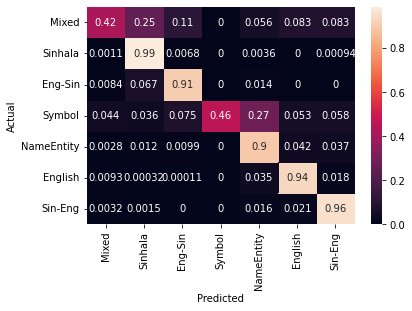

09/22/2021 23:51:47 INFO LSTM_experiment: "Completed after 0:32:54"


Running experiment 2 of 5 with config {'epochs': 25, 'embedding_dim': 150, 'hidden_dim': 150, 'weight_decay': 1e-05, 'lr': 0.1, 'optimizer': 'adam', 'seed': 1, 'batch_size': 64}


09/22/2021 23:51:49 INFO LSTM_experiment: "Running command 'main'"
09/22/2021 23:51:49 INFO LSTM_experiment: "Started run with ID "2""
09/22/2021 23:51:49 INFO main: "Tensor Board logging enabled, configuring SummaryWriter's"
09/22/2021 23:51:49 INFO main: "Tensor Board logs will be written to /content/drive/MyDrive/FYP/Final/Experiment/Baseline/withSenId_2/2/tb_logs"
09/22/2021 23:51:49 INFO main: "Loading idx maps"
09/22/2021 23:51:50 INFO main: "Loading LSTM model"
09/22/2021 23:51:50 INFO main: "Loading test data"
09/22/2021 23:51:51 INFO main: "Loading train data"
09/22/2021 23:51:53 INFO main: "Training model"
09/22/2021 23:51:53 INFO main: "Running for 25 epochs"
09/22/2021 23:53:01 INFO main: "Average training error in epoch 1: 0.82645 and training accuracy: 0.7718"
09/22/2021 23:53:08 INFO main: "Average total loss dev: 0.79825, accuracy: 0.7402, "
09/22/2021 23:53:08 INFO main: "Time spent in epoch 1: 75.14 "
09/22/2021 23:54:18 INFO main: "Average training error in epoch 2: 

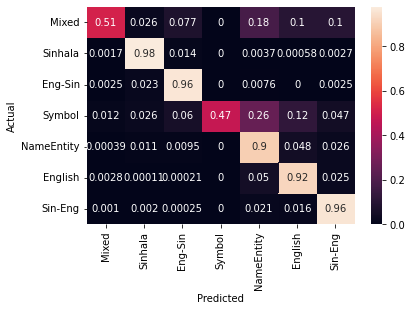

09/23/2021 00:24:51 INFO LSTM_experiment: "Completed after 0:33:02"


Running experiment 3 of 5 with config {'epochs': 25, 'embedding_dim': 150, 'hidden_dim': 150, 'weight_decay': 1e-05, 'lr': 0.1, 'optimizer': 'adam', 'seed': 1, 'batch_size': 64}


09/23/2021 00:24:54 INFO LSTM_experiment: "Running command 'main'"
09/23/2021 00:24:54 INFO LSTM_experiment: "Started run with ID "3""
09/23/2021 00:24:54 INFO main: "Tensor Board logging enabled, configuring SummaryWriter's"
09/23/2021 00:24:54 INFO main: "Tensor Board logs will be written to /content/drive/MyDrive/FYP/Final/Experiment/Baseline/withSenId_2/3/tb_logs"
09/23/2021 00:24:54 INFO main: "Loading idx maps"
09/23/2021 00:24:54 INFO main: "Loading LSTM model"
09/23/2021 00:24:54 INFO main: "Loading test data"
09/23/2021 00:24:55 INFO main: "Loading train data"
09/23/2021 00:24:57 INFO main: "Training model"
09/23/2021 00:24:57 INFO main: "Running for 25 epochs"
09/23/2021 00:26:06 INFO main: "Average training error in epoch 1: 0.78150 and training accuracy: 0.7800"
09/23/2021 00:26:13 INFO main: "Average total loss dev: 0.67168, accuracy: 0.7889, "
09/23/2021 00:26:13 INFO main: "Time spent in epoch 1: 75.74 "
09/23/2021 00:27:23 INFO main: "Average training error in epoch 2: 

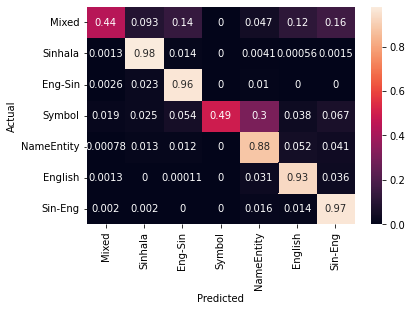

09/23/2021 00:59:56 INFO LSTM_experiment: "Completed after 0:35:03"


Running experiment 4 of 5 with config {'epochs': 25, 'embedding_dim': 150, 'hidden_dim': 150, 'weight_decay': 1e-05, 'lr': 0.1, 'optimizer': 'adam', 'seed': 1, 'batch_size': 64}


09/23/2021 00:59:59 INFO LSTM_experiment: "Running command 'main'"
09/23/2021 00:59:59 INFO LSTM_experiment: "Started run with ID "4""
09/23/2021 00:59:59 INFO main: "Tensor Board logging enabled, configuring SummaryWriter's"
09/23/2021 00:59:59 INFO main: "Tensor Board logs will be written to /content/drive/MyDrive/FYP/Final/Experiment/Baseline/withSenId_2/4/tb_logs"
09/23/2021 00:59:59 INFO main: "Loading idx maps"
09/23/2021 00:59:59 INFO main: "Loading LSTM model"
09/23/2021 00:59:59 INFO main: "Loading test data"
09/23/2021 01:00:00 INFO main: "Loading train data"
09/23/2021 01:00:02 INFO main: "Training model"
09/23/2021 01:00:02 INFO main: "Running for 25 epochs"
09/23/2021 01:01:13 INFO main: "Average training error in epoch 1: 0.81378 and training accuracy: 0.7854"
09/23/2021 01:01:20 INFO main: "Average total loss dev: 0.55937, accuracy: 0.8270, "
09/23/2021 01:01:20 INFO main: "Time spent in epoch 1: 77.76 "
09/23/2021 01:02:31 INFO main: "Average training error in epoch 2: 

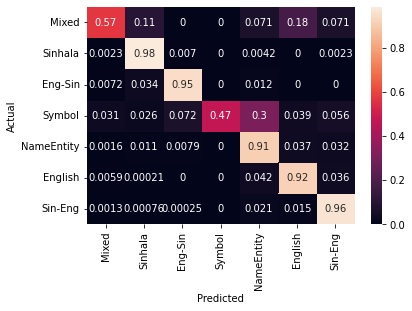

09/23/2021 01:33:42 INFO LSTM_experiment: "Completed after 0:33:44"


Running experiment 5 of 5 with config {'epochs': 25, 'embedding_dim': 150, 'hidden_dim': 150, 'weight_decay': 1e-05, 'lr': 0.1, 'optimizer': 'adam', 'seed': 1, 'batch_size': 64}


09/23/2021 01:33:44 INFO LSTM_experiment: "Running command 'main'"
09/23/2021 01:33:44 INFO LSTM_experiment: "Started run with ID "5""
09/23/2021 01:33:44 INFO main: "Tensor Board logging enabled, configuring SummaryWriter's"
09/23/2021 01:33:44 INFO main: "Tensor Board logs will be written to /content/drive/MyDrive/FYP/Final/Experiment/Baseline/withSenId_2/5/tb_logs"
09/23/2021 01:33:45 INFO main: "Loading idx maps"
09/23/2021 01:33:45 INFO main: "Loading LSTM model"
09/23/2021 01:33:45 INFO main: "Loading test data"
09/23/2021 01:33:46 INFO main: "Loading train data"
09/23/2021 01:33:48 INFO main: "Training model"
09/23/2021 01:33:48 INFO main: "Running for 25 epochs"
09/23/2021 01:34:58 INFO main: "Average training error in epoch 1: 0.82501 and training accuracy: 0.7825"
09/23/2021 01:35:05 INFO main: "Average total loss dev: 0.71093, accuracy: 0.7840, "
09/23/2021 01:35:05 INFO main: "Time spent in epoch 1: 76.94 "
09/23/2021 01:36:16 INFO main: "Average training error in epoch 2: 

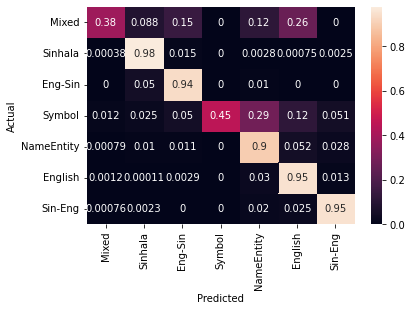

09/23/2021 02:08:07 INFO LSTM_experiment: "Completed after 0:34:23"


All experiments are completed
Accuracy: 0.8852122797668072
Precision weighted average: 0.9114916252171145
Recall weighted average: 0.8852122797668072
F1 weighted average: 0.8827625797127647
Precision-macro: 0.7303270038964714
Recall-macro: 0.8069908948070532
F1-macro: 0.7293312362252363


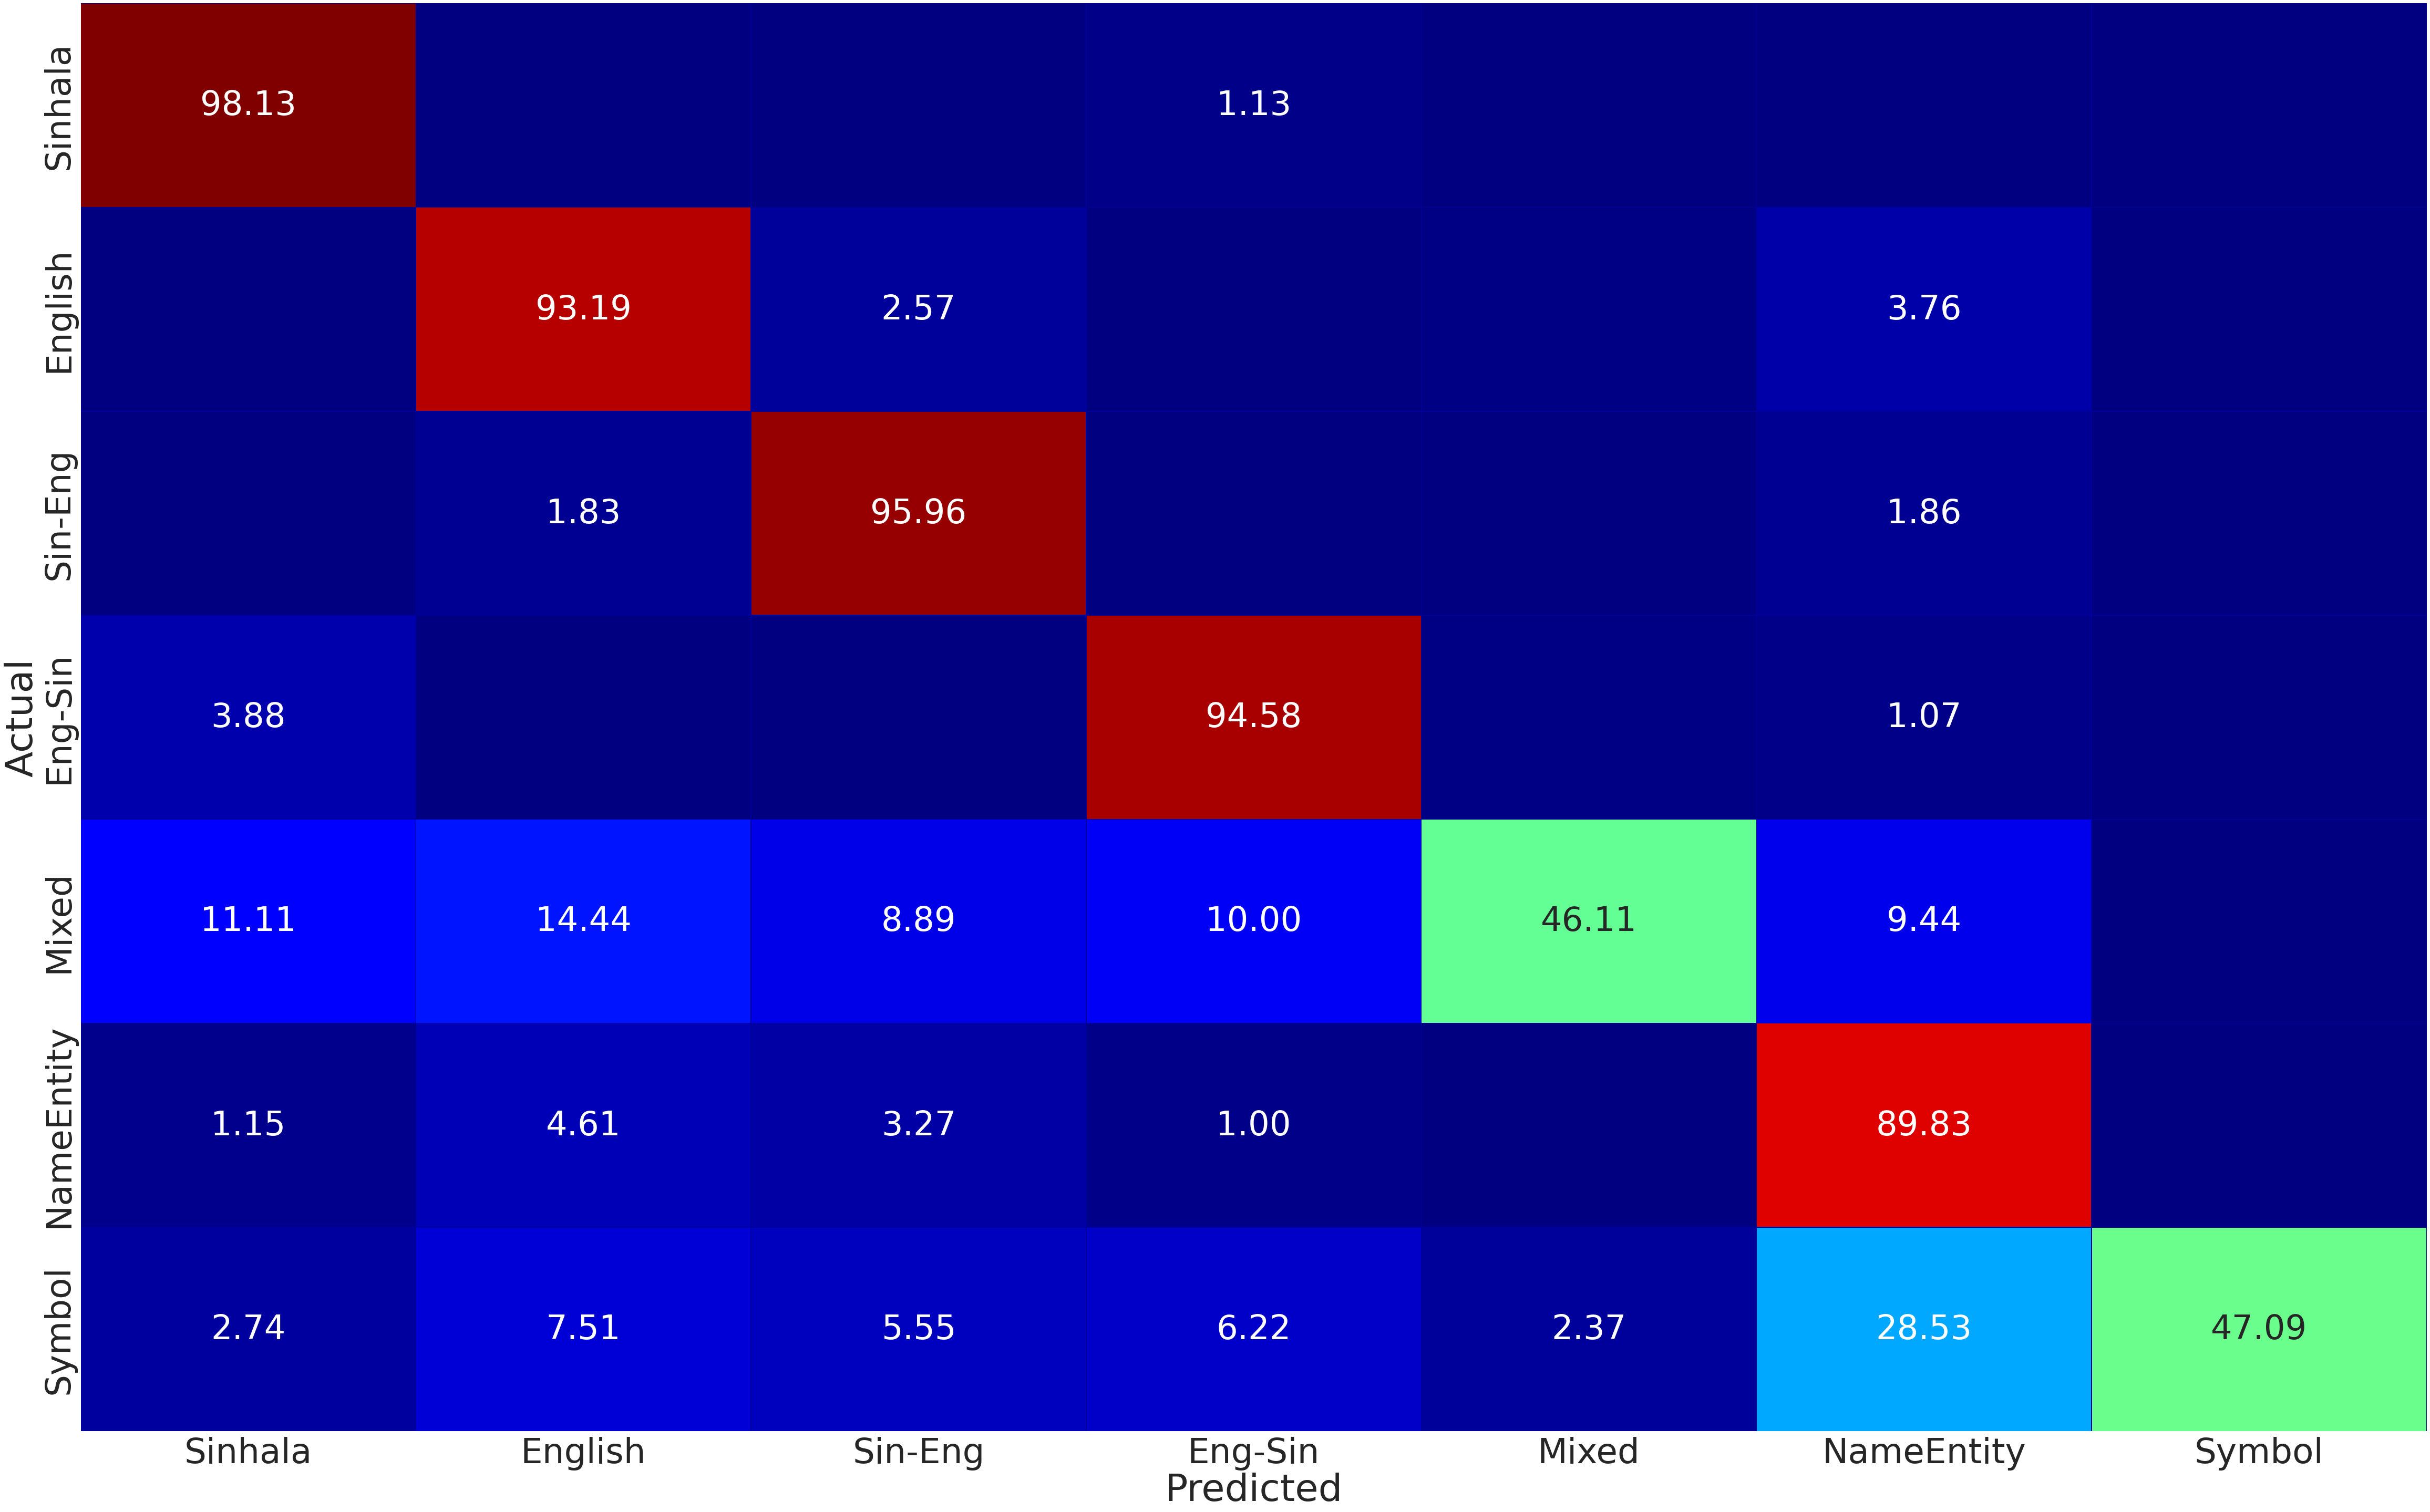

In [ ]:
LSTM_exp.observers.append(FileStorageObserver('/content/drive/MyDrive/FYP/Final/Experiment/Baseline/withSenId_2'))
epochs = 25
embedding_dims = [150]
hidden_dims = [150]
weight_decay = 0.00001
seed = 1
lr = 0.1
batch_size = 64
folds = 5
# sgd and adam are possible optimizers
optimizer = "adam"
count = 1
total = len(embedding_dims) * len(hidden_dims) * folds

for i in range(folds):
    sleep(2)
    @data_loading_ingredient.config
    def update_cfg():
        train_path = "/content/drive/MyDrive/FYP/Final/dataset/LID_Folds/withSenID_2"
        test_path = "/content/drive/MyDrive/FYP/Final/dataset/LID_Folds/withSenID_2/sub_dataset"
        train_folds = [(i + j + 1) % folds for j in range(folds - 1)]
        test_folds = [i]
    for emb_dim in embedding_dims:
        for hid_dim in hidden_dims:
            config_updates = {
                'epochs': epochs,
                'embedding_dim': emb_dim,
                'hidden_dim': hid_dim,
                'weight_decay': weight_decay,
                'lr': lr,
                'optimizer': optimizer,
                'seed': seed,
                'batch_size': batch_size,
            }
            print("Running experiment {0} of {1} with config {2}".format(count, total, config_updates))
            count += 1
            LSTM_exp.run(config_updates=config_updates)
print("All experiments are completed")

base_path = Path('/content/drive/MyDrive/FYP/Final/Experiment/Baseline/withSenId_2')
get_statistics(base_path)
